# **DEPENDENCIES**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **DATASET**

In [41]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(mnist_dataset))
test_size = len(mnist_dataset) - train_size
train_dataset, test_dataset = random_split(mnist_dataset, [train_size, test_size])

batch_size = 10000
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Xtr, Ytr = next(iter(train_loader))
Xte, Yte = next(iter(test_loader))
Xtr = Xtr.view(Xtr.size(0), -1)
Xte = Xte.view(Xte.size(0), -1)

In [42]:
Xtr = Xtr.detach().numpy()
Xte = Xte.detach().numpy()
Ytr = Ytr.detach().numpy()
Yte = Yte.detach().numpy()
Ytr = np.eye(10)[Ytr]
Yte = np.eye(10)[Yte]

#### **Utils**

In [23]:
def plot_history(history, accu=False, title="Training vs Validation Loss"):
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    sns.set_style("darkgrid")
    sns.lineplot(
        x=range(1, len(history["loss"]) + 1),
        y=history["loss"],
        label="Training Loss",
    )
    sns.lineplot(
        x=range(1, len(history["val_loss"]) + 1),
        y=history["val_loss"],
        label="Validation Loss",
    )
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    if accu and "accuracy" in history and "val_accuracy" in history:
        plt.subplot(1, 2, 2)
        sns.set_style("darkgrid")
        sns.lineplot(
            x=range(1, len(history["accuracy"]) + 1),
            y=history["accuracy"],
            label="Training Accuracy",
        )
        sns.lineplot(
            x=range(1, len(history["val_accuracy"]) + 1),
            y=history["val_accuracy"],
            label="Validation Accuracy",
        )
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

    plt.suptitle(title)
    plt.show()


def plot_images(
    original_images, reconstructed_images, title="Original vs Reconstructed Images"
):
    fig, axes = plt.subplots(2, 10, figsize=(8, 2))
    fig.suptitle(title)

    for i in range(10):
        axes[0, i].imshow(original_images[i].reshape(28, 28), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap="gray")
        axes[1, i].axis("off")

    plt.tight_layout()

    plt.show()

#### **Neural Network (scratch)**

In [24]:
class FeedForwardNet:
    def __init__(self, inp_units, hid_units, out_units):
        self.inp_units = inp_units
        self.hid_units = hid_units
        self.out_units = out_units

        # Parameters
        self.W1 = np.random.randn(self.inp_units, self.hid_units)
        self.b1 = np.random.randn(self.hid_units)
        self.W2 = np.random.randn(self.hid_units, self.out_units)
        self.b2 = np.random.randn(self.out_units)

    def _sigmoid(self, x):
        # Clip x values to prevent overflow
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def _sigmoid_prime(self, x):
        return self._sigmoid(x) * (1 - self._sigmoid(x))

    def _mse(self, y, y_hat):
        return np.square(y - y_hat).mean()

    def _mse_prime(self, y, y_hat):
        return 2 * (y_hat - y) / y.size

    def _accuracy(self, y, y_hat, threshold=0.5):
        return np.sum(y == (y_hat > threshold)) / y.size

    def _forward_h(self, x):
        return self._sigmoid(np.dot(x, self.W1) + self.b1)

    def _forward_o(self, x):
        return self._sigmoid(np.dot(x, self.W2) + self.b2)

    def _forward(self, x):
        return self._forward_o(self._forward_h(x))

    def _backward_o(self, x, y, y_hat):
        dL_dz = self._mse_prime(y, y_hat) * self._sigmoid_prime(y_hat)
        dL_dW = np.dot(self._forward_h(x).T, dL_dz)
        dL_db = np.sum(dL_dz, axis=0)
        return dL_dW, dL_db, dL_dz

    def _backward_h(self, x, dL_dz):
        dL_dW = np.dot(
            x.T, np.dot(dL_dz, self.W2.T) * self._sigmoid_prime(self._forward_h(x))
        )
        dL_db = np.sum(
            np.dot(dL_dz, self.W2.T) * self._sigmoid_prime(self._forward_h(x)),
            axis=0,
        )
        return dL_dW, dL_db

    def _backward(self, x, y, y_hat, learning_rate):
        dL_dW2, dL_db2, dL_dz2 = self._backward_o(x, y, y_hat)
        dL_dW1, dL_db1 = self._backward_h(x, dL_dz2)
        self.W1 -= learning_rate * dL_dW1
        self.b1 -= learning_rate * dL_db1
        self.W2 -= learning_rate * dL_dW2
        self.b2 -= learning_rate * dL_db2

    def train(self, x, y, x_val, y_val, batch_size=16, epochs=10, learning_rate=1e-3):
        history = {
            "loss": [],
            "val_loss": [],
            "accuracy": [],
            "val_accuracy": [],
        }
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")
            for i in tqdm(range(0, x.shape[0], batch_size)):
                x_batch = x[i : i + batch_size]
                y_batch = y[i : i + batch_size]
                y_hat = self._forward(x_batch)
                self._backward(x_batch, y_batch, y_hat, learning_rate)
            y_hat = self._forward(x)
            y_val_hat = self._forward(x_val)
            history["loss"].append(self._mse(y, y_hat))
            history["val_loss"].append(self._mse(y_val, y_val_hat))
            history["accuracy"].append(self._accuracy(y, y_hat))
            history["val_accuracy"].append(self._accuracy(y_val, y_val_hat))
        return history

Epoch 1/25


100%|██████████| 625/625 [00:03<00:00, 187.84it/s]


Epoch 2/25


100%|██████████| 625/625 [00:01<00:00, 389.97it/s]


Epoch 3/25


100%|██████████| 625/625 [00:01<00:00, 406.09it/s]


Epoch 4/25


100%|██████████| 625/625 [00:01<00:00, 407.83it/s]


Epoch 5/25


100%|██████████| 625/625 [00:01<00:00, 404.47it/s]


Epoch 6/25


100%|██████████| 625/625 [00:01<00:00, 385.96it/s]


Epoch 7/25


100%|██████████| 625/625 [00:02<00:00, 275.37it/s]


Epoch 8/25


100%|██████████| 625/625 [00:03<00:00, 186.63it/s]


Epoch 9/25


100%|██████████| 625/625 [00:01<00:00, 356.75it/s]


Epoch 10/25


100%|██████████| 625/625 [00:03<00:00, 188.16it/s]


Epoch 11/25


100%|██████████| 625/625 [00:01<00:00, 409.86it/s]


Epoch 12/25


100%|██████████| 625/625 [00:01<00:00, 403.25it/s]


Epoch 13/25


100%|██████████| 625/625 [00:02<00:00, 218.98it/s]


Epoch 14/25


100%|██████████| 625/625 [00:03<00:00, 196.49it/s]


Epoch 15/25


100%|██████████| 625/625 [00:01<00:00, 393.10it/s]


Epoch 16/25


100%|██████████| 625/625 [00:01<00:00, 396.59it/s]


Epoch 17/25


100%|██████████| 625/625 [00:01<00:00, 386.83it/s]


Epoch 18/25


100%|██████████| 625/625 [00:01<00:00, 400.56it/s]


Epoch 19/25


100%|██████████| 625/625 [00:01<00:00, 395.38it/s]


Epoch 20/25


100%|██████████| 625/625 [00:02<00:00, 283.77it/s]


Epoch 21/25


100%|██████████| 625/625 [00:03<00:00, 196.54it/s]


Epoch 22/25


100%|██████████| 625/625 [00:01<00:00, 321.55it/s]


Epoch 23/25


100%|██████████| 625/625 [00:01<00:00, 400.40it/s]


Epoch 24/25


100%|██████████| 625/625 [00:01<00:00, 408.98it/s]


Epoch 25/25


100%|██████████| 625/625 [00:01<00:00, 410.38it/s]


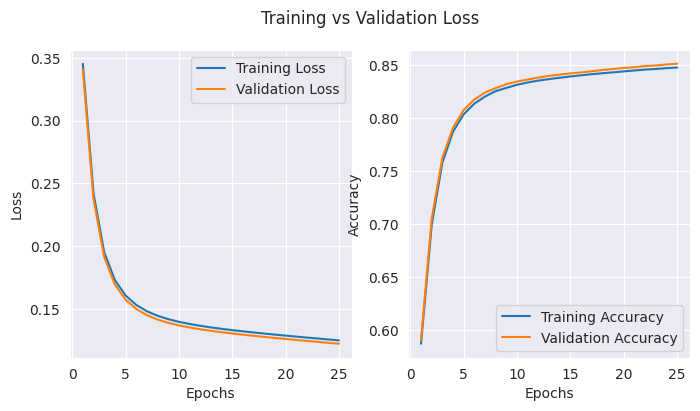

In [43]:
# Training
model = FeedForwardNet(784, 128, 10)
history = model.train(Xtr, Ytr, Xte, Yte, epochs=25)

# Create a dictionary for models to store best metrics
model_metrics = {
    "NN-Scratch": {
        "loss": min(history["val_loss"]),
        "accuracy": max(history["val_accuracy"]),
    }
}

# Plotting
plot_history(history, accu=True)

In [44]:
Xtr = torch.from_numpy(Xtr).float().to(device)
Xte = torch.from_numpy(Xte).float().to(device)
Ytr = torch.from_numpy(Ytr).float().to(device)
Yte = torch.from_numpy(Yte).float().to(device)

#### **Autoencoder**

In [45]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            nn.Linear(128, 28 * 28),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Epoch 1/25


100%|██████████| 625/625 [00:00<00:00, 1058.60it/s]


Epoch 2/25


100%|██████████| 625/625 [00:00<00:00, 945.60it/s]


Epoch 3/25


100%|██████████| 625/625 [00:00<00:00, 1020.91it/s]


Epoch 4/25


100%|██████████| 625/625 [00:00<00:00, 1038.50it/s]


Epoch 5/25


100%|██████████| 625/625 [00:00<00:00, 1057.48it/s]


Epoch 6/25


100%|██████████| 625/625 [00:00<00:00, 1068.84it/s]


Epoch 7/25


100%|██████████| 625/625 [00:00<00:00, 1055.64it/s]


Epoch 8/25


100%|██████████| 625/625 [00:00<00:00, 947.49it/s]


Epoch 9/25


100%|██████████| 625/625 [00:00<00:00, 894.28it/s]


Epoch 10/25


100%|██████████| 625/625 [00:00<00:00, 938.01it/s]


Epoch 11/25


100%|██████████| 625/625 [00:00<00:00, 910.48it/s]


Epoch 12/25


100%|██████████| 625/625 [00:00<00:00, 905.13it/s]


Epoch 13/25


100%|██████████| 625/625 [00:00<00:00, 975.04it/s] 


Epoch 14/25


100%|██████████| 625/625 [00:00<00:00, 1082.96it/s]


Epoch 15/25


100%|██████████| 625/625 [00:00<00:00, 1058.54it/s]


Epoch 16/25


100%|██████████| 625/625 [00:00<00:00, 1048.82it/s]


Epoch 17/25


100%|██████████| 625/625 [00:00<00:00, 1114.06it/s]


Epoch 18/25


100%|██████████| 625/625 [00:00<00:00, 1066.16it/s]


Epoch 19/25


100%|██████████| 625/625 [00:00<00:00, 1071.44it/s]


Epoch 20/25


100%|██████████| 625/625 [00:00<00:00, 1060.08it/s]


Epoch 21/25


100%|██████████| 625/625 [00:00<00:00, 1042.30it/s]


Epoch 22/25


100%|██████████| 625/625 [00:00<00:00, 1098.05it/s]


Epoch 23/25


100%|██████████| 625/625 [00:00<00:00, 1066.18it/s]


Epoch 24/25


100%|██████████| 625/625 [00:00<00:00, 1101.13it/s]


Epoch 25/25


100%|██████████| 625/625 [00:00<00:00, 1070.42it/s]


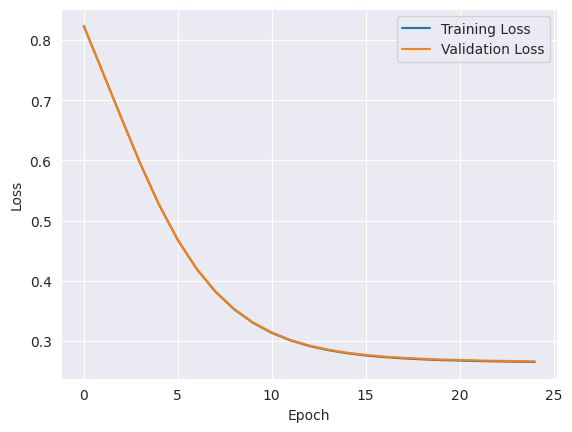

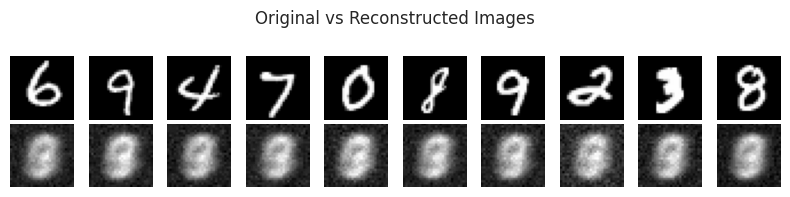

In [46]:
# Training
model_ae = Autoencoder()
model_ae = model_ae.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model_ae.parameters(), lr=1e-3)
epochs = 25
batch_size = 16
history = {
    "loss": [],
    "val_loss": [],
}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in tqdm(range(0, Xtr.size(0), batch_size)):
        x_batch = Xtr[i : i + batch_size]
        y_batch = Xtr[i : i + batch_size]
        x_enc = model_ae.encoder(x_batch)
        x_rec = model_ae.decoder(x_enc)
        loss_val = loss(x_rec, y_batch)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

    x_enc = model_ae.encoder(Xtr)
    x_rec = model_ae.decoder(x_enc)
    x_val_enc = model_ae.encoder(Xte)
    x_val_rec = model_ae.decoder(x_val_enc)
    history["loss"].append(loss(x_rec, Xtr).item())
    history["val_loss"].append(loss(x_val_rec, Xte).item())

# Plotting
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting
x_enc = model_ae.encoder(Xte)
x_rec = model_ae.decoder(x_enc).detach().cpu().numpy()
plot_images(Xte.detach().cpu().numpy(), x_rec)

#### **MLP with Sigmoid, MSE**

In [29]:
class MultiLayerPerceptron3(nn.Module):
    def __init__(self):
        super(MultiLayerPerceptron3, self).__init__()
        self.h = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.Sigmoid(),
        )
        self.o = nn.Sequential(
            nn.Linear(128, 10),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.h(x)
        x = self.o(x)
        return x

Epoch 1/25


100%|██████████| 625/625 [00:00<00:00, 1034.73it/s]


Epoch 2/25


100%|██████████| 625/625 [00:00<00:00, 1028.47it/s]


Epoch 3/25


100%|██████████| 625/625 [00:00<00:00, 1044.29it/s]


Epoch 4/25


100%|██████████| 625/625 [00:00<00:00, 1003.97it/s]


Epoch 5/25


100%|██████████| 625/625 [00:00<00:00, 1030.79it/s]


Epoch 6/25


100%|██████████| 625/625 [00:00<00:00, 991.06it/s] 


Epoch 7/25


100%|██████████| 625/625 [00:00<00:00, 1012.31it/s]


Epoch 8/25


100%|██████████| 625/625 [00:00<00:00, 1037.76it/s]


Epoch 9/25


100%|██████████| 625/625 [00:00<00:00, 984.94it/s] 


Epoch 10/25


100%|██████████| 625/625 [00:00<00:00, 1025.97it/s]


Epoch 11/25


100%|██████████| 625/625 [00:00<00:00, 1017.00it/s]


Epoch 12/25


100%|██████████| 625/625 [00:00<00:00, 885.01it/s]


Epoch 13/25


100%|██████████| 625/625 [00:00<00:00, 830.37it/s]


Epoch 14/25


100%|██████████| 625/625 [00:00<00:00, 837.92it/s]


Epoch 15/25


100%|██████████| 625/625 [00:00<00:00, 895.62it/s]


Epoch 16/25


100%|██████████| 625/625 [00:00<00:00, 845.56it/s]


Epoch 17/25


100%|██████████| 625/625 [00:00<00:00, 1012.23it/s]


Epoch 18/25


100%|██████████| 625/625 [00:00<00:00, 1023.79it/s]


Epoch 19/25


100%|██████████| 625/625 [00:00<00:00, 1022.97it/s]


Epoch 20/25


100%|██████████| 625/625 [00:00<00:00, 1049.89it/s]


Epoch 21/25


100%|██████████| 625/625 [00:00<00:00, 1034.61it/s]


Epoch 22/25


100%|██████████| 625/625 [00:00<00:00, 1033.76it/s]


Epoch 23/25


100%|██████████| 625/625 [00:00<00:00, 1047.18it/s]


Epoch 24/25


100%|██████████| 625/625 [00:00<00:00, 1019.69it/s]


Epoch 25/25


100%|██████████| 625/625 [00:00<00:00, 1025.56it/s]


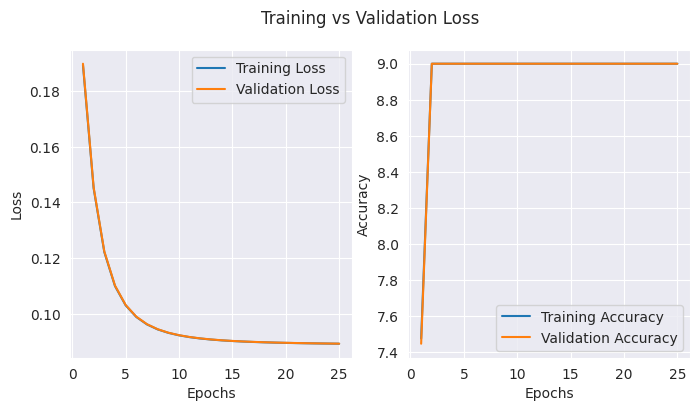

In [47]:
# Training
model_3 = MultiLayerPerceptron3()
model_3 = model_3.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=1e-3)
epochs = 25
batch_size = 16
history = {
    "loss": [],
    "val_loss": [],
    "accuracy": [],
    "val_accuracy": [],
}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in tqdm(range(0, Xtr.size(0), batch_size)):
        x_batch = Xtr[i : i + batch_size]
        y_batch = Ytr[i : i + batch_size]
        y_hat = model_3.h(x_batch)
        y_hat = model_3.o(y_hat)
        loss_val = loss(y_hat, y_batch)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

    y_hat = model_3.h(Xtr)
    y_hat = model_3.o(y_hat)
    y_hat_val = model_3.h(Xte)
    y_hat_val = model_3.o(y_hat_val)
    history["loss"].append(loss(y_hat, Ytr).item())
    history["val_loss"].append(loss(y_hat_val, Yte).item())
    history["accuracy"].append(
        torch.sum(Ytr == (y_hat > 0.5)).item() / Ytr.size(0)
    )
    history["val_accuracy"].append(
        torch.sum(Yte == (y_hat_val > 0.5)).item() / Yte.size(0)
    )

# Update model metrics
model_metrics["MLP-3"] = {
    "loss": min(history["val_loss"]),
    "accuracy": max(history["val_accuracy"]),
}
# Plotting
plot_history(history, accu=True)

In [48]:
class MultiLayerPerceptron4(nn.Module):
    def __init__(self):
        super(MultiLayerPerceptron4, self).__init__()
        self.h = model_ae.encoder
        self.h[0].weight.requires_grad = True
        self.o = nn.Sequential(
            nn.Linear(128, 10),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.h(x)
        x = self.o(x)
        return x

Epoch 1/25


100%|██████████| 625/625 [00:00<00:00, 856.93it/s]


Epoch 2/25


100%|██████████| 625/625 [00:00<00:00, 891.49it/s]


Epoch 3/25


100%|██████████| 625/625 [00:00<00:00, 888.79it/s]


Epoch 4/25


100%|██████████| 625/625 [00:00<00:00, 843.98it/s]


Epoch 5/25


100%|██████████| 625/625 [00:00<00:00, 894.57it/s]


Epoch 6/25


100%|██████████| 625/625 [00:00<00:00, 985.97it/s]


Epoch 7/25


100%|██████████| 625/625 [00:00<00:00, 961.06it/s]


Epoch 8/25


100%|██████████| 625/625 [00:00<00:00, 1043.01it/s]


Epoch 9/25


100%|██████████| 625/625 [00:00<00:00, 1030.90it/s]


Epoch 10/25


100%|██████████| 625/625 [00:00<00:00, 991.50it/s]


Epoch 11/25


100%|██████████| 625/625 [00:00<00:00, 1017.69it/s]


Epoch 12/25


100%|██████████| 625/625 [00:00<00:00, 971.91it/s]


Epoch 13/25


100%|██████████| 625/625 [00:00<00:00, 992.79it/s]


Epoch 14/25


100%|██████████| 625/625 [00:00<00:00, 1008.24it/s]


Epoch 15/25


100%|██████████| 625/625 [00:00<00:00, 983.19it/s]


Epoch 16/25


100%|██████████| 625/625 [00:00<00:00, 1011.44it/s]


Epoch 17/25


100%|██████████| 625/625 [00:00<00:00, 1015.95it/s]


Epoch 18/25


100%|██████████| 625/625 [00:00<00:00, 996.98it/s]


Epoch 19/25


100%|██████████| 625/625 [00:00<00:00, 999.03it/s]


Epoch 20/25


100%|██████████| 625/625 [00:00<00:00, 990.08it/s] 


Epoch 21/25


100%|██████████| 625/625 [00:00<00:00, 896.70it/s]


Epoch 22/25


100%|██████████| 625/625 [00:00<00:00, 869.49it/s]


Epoch 23/25


100%|██████████| 625/625 [00:00<00:00, 844.01it/s]


Epoch 24/25


100%|██████████| 625/625 [00:00<00:00, 880.99it/s]


Epoch 25/25


100%|██████████| 625/625 [00:00<00:00, 830.16it/s]


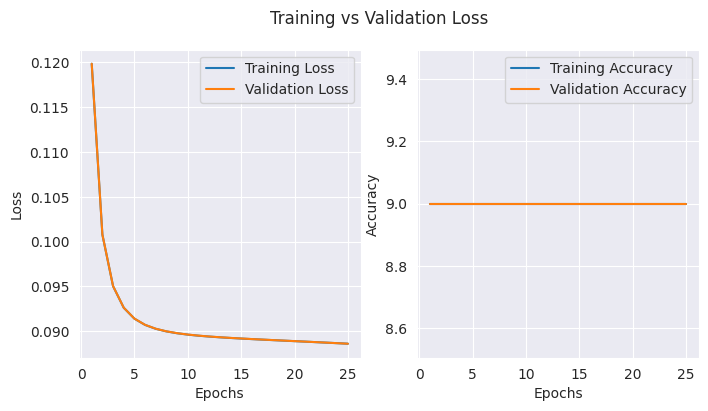

In [49]:
# Training
model_4 = MultiLayerPerceptron4()
model_4 = model_4.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=1e-3)
epochs = 25
batch_size = 16
history = {
    "loss": [],
    "val_loss": [],
    "accuracy": [],
    "val_accuracy": [],
}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in tqdm(range(0, Xtr.size(0), batch_size)):
        x_batch = Xtr[i : i + batch_size]
        y_batch = Ytr[i : i + batch_size]
        y_hat = model_4.h(x_batch)
        y_hat = model_4.o(y_hat)
        loss_val = loss(y_hat, y_batch)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

    y_hat = model_4.h(Xtr)
    y_hat = model_4.o(y_hat)
    y_hat_val = model_4.h(Xte)
    y_hat_val = model_4.o(y_hat_val)
    history["loss"].append(loss(y_hat, Ytr).item())
    history["val_loss"].append(loss(y_hat_val, Yte).item())
    history["accuracy"].append(
        torch.sum(Ytr == (y_hat > 0.5)).item() / Ytr.size(0)
    )
    history["val_accuracy"].append(
        torch.sum(Yte == (y_hat_val > 0.5)).item() / Yte.size(0)
    )

# Update model metrics
model_metrics["MLP-4"] = {
    "loss": min(history["val_loss"]),
    "accuracy": max(history["val_accuracy"]),
}

# Plotting
plot_history(history, accu=True)

#### **LeNet**

In [33]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(256, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = x.reshape(-1, 1, 28, 28)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

Epoch 1/25


100%|██████████| 625/625 [00:01<00:00, 434.15it/s]


Epoch 2/25


100%|██████████| 625/625 [00:01<00:00, 380.17it/s]


Epoch 3/25


100%|██████████| 625/625 [00:01<00:00, 413.55it/s]


Epoch 4/25


100%|██████████| 625/625 [00:01<00:00, 475.02it/s]


Epoch 5/25


100%|██████████| 625/625 [00:01<00:00, 487.76it/s]


Epoch 6/25


100%|██████████| 625/625 [00:01<00:00, 475.74it/s]


Epoch 7/25


100%|██████████| 625/625 [00:01<00:00, 488.56it/s]


Epoch 8/25


100%|██████████| 625/625 [00:01<00:00, 477.86it/s]


Epoch 9/25


100%|██████████| 625/625 [00:01<00:00, 477.09it/s]


Epoch 10/25


100%|██████████| 625/625 [00:01<00:00, 475.12it/s]


Epoch 11/25


100%|██████████| 625/625 [00:01<00:00, 386.33it/s]


Epoch 12/25


100%|██████████| 625/625 [00:01<00:00, 386.46it/s]


Epoch 13/25


100%|██████████| 625/625 [00:01<00:00, 492.05it/s]


Epoch 14/25


100%|██████████| 625/625 [00:01<00:00, 481.20it/s]


Epoch 15/25


100%|██████████| 625/625 [00:01<00:00, 474.82it/s]


Epoch 16/25


100%|██████████| 625/625 [00:01<00:00, 477.88it/s]


Epoch 17/25


100%|██████████| 625/625 [00:01<00:00, 482.10it/s]


Epoch 18/25


100%|██████████| 625/625 [00:01<00:00, 484.06it/s]


Epoch 19/25


100%|██████████| 625/625 [00:01<00:00, 474.73it/s]


Epoch 20/25


100%|██████████| 625/625 [00:01<00:00, 410.49it/s]


Epoch 21/25


100%|██████████| 625/625 [00:01<00:00, 393.17it/s]


Epoch 22/25


100%|██████████| 625/625 [00:01<00:00, 415.78it/s]


Epoch 23/25


100%|██████████| 625/625 [00:01<00:00, 483.50it/s]


Epoch 24/25


100%|██████████| 625/625 [00:01<00:00, 493.94it/s]


Epoch 25/25


100%|██████████| 625/625 [00:01<00:00, 485.78it/s]


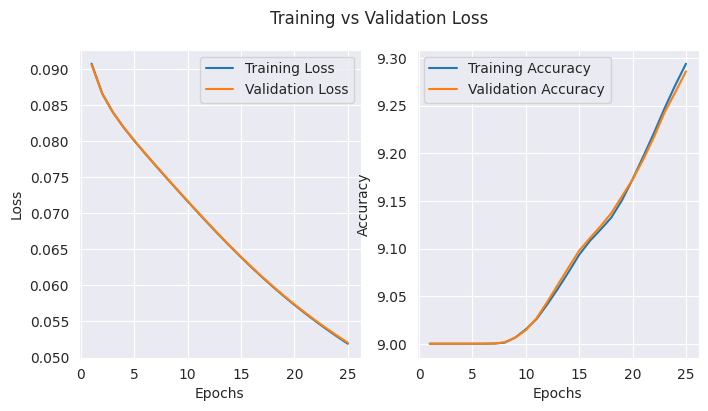

In [50]:
# Training
lenet = LeNet5(10)
lenet = lenet.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.SGD(lenet.parameters(), lr=1e-3)
epochs = 25
batch_size = 16
history = {
    "loss": [],
    "val_loss": [],
    "accuracy": [],
    "val_accuracy": [],
}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in tqdm(range(0, Xtr.size(0), batch_size)):
        x_batch = Xtr[i : i + batch_size]
        y_batch = Ytr[i : i + batch_size]
        y_hat = lenet.forward(x_batch)
        loss_val = loss(y_hat, y_batch)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

    y_hat = lenet.forward(Xtr)
    y_hat_val = lenet.forward(Xte)
    history["loss"].append(loss(y_hat, Ytr).item())
    history["val_loss"].append(loss(y_hat_val, Yte).item())
    history["accuracy"].append(
        torch.sum(Ytr == (y_hat > 0.5)).item() / Ytr.size(0)
    )
    history["val_accuracy"].append(
        torch.sum(Yte == (y_hat_val > 0.5)).item() / Yte.size(0)
    )

# Update model metrics
model_metrics["LeNet5"] = {
    "loss": min(history["val_loss"]),
    "accuracy": max(history["val_accuracy"]),
}

# Plotting
plot_history(history, accu=True)

## **Comparison**

In [57]:
import pandas as pd

model_metrics["NN-Scratch"]["accuracy"] = model_metrics["NN-Scratch"]["accuracy"] * 10
model_metrics = pd.DataFrame(model_metrics).T
print(model_metrics)

# Best Model
best_model = model_metrics[
    model_metrics["accuracy"] == model_metrics["accuracy"].max()
].index[0]
print(f"Best Model: {best_model}")

                loss  accuracy
NN-Scratch  0.122535    8.5107
MLP-3       0.089255    9.0000
MLP-4       0.088614    9.0000
LeNet5      0.052066    9.2861
Best Model: LeNet5


LeNet is the best architecture, in this run, DBN in MLP4 imporved validation loss. LeNet5's loss was way better than any of the other models.

<!-- Implement a 3 layer MLP using PyTorch use sigmoid func;on as
ac;va;on in all layers and ini;alize the first 2-layers with pretrained
weights as per the deep belief network using autoencoders then fine
tune it using MSE and SGD with autograd. Use appropriate learning
rate or a momentum on weights. Compare the results of the III and IV
for training vs valida;on losses and accuracies. Plot the train and
valida;on curves in a single figure. -->